#### Load required libraries

In [1]:
import os
import numpy as np
from pyviscous import pyviscous as vs
from pyviscous import plot as vsplt

#### Load Rosenbrock function
In the two-dimensional form, the Rosenbrock function is defined as ([Rosenbrock, 1960](https://doi.org/10.1093/comjnl/3.3.175)):
$$ Y = {100(X_2-X_1^2)^2 + (1-X_1)^2}, X_1, X_2 \in [-2,2] $$

In [2]:
def Rosenbrock_function(x):
    ''' Rosenbrock function
    -------
    x: input array, shape (n_samples,2).
    y: output array, shape (n_samples,1).'''
    
    y = 100*np.power(x[:,1]-np.power(x[:,0],2),2) + np.power(1-x[:,0],2)
    
    # If shape(n_samples,), reshape to (n_samples,1).
    if y.ndim == 1:
        y = y.reshape(-1, 1)

    return y

#### Configurations

In [3]:
# Define a folder to save sensitivity results.
outputDir = os.path.join('.','rosebrock')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# Define other variables
nVar            = 2      # number of input x variables
paramLowerLimit = -2     # lower limit of x
paramUpperLimit = 2      # upper limit of x
nSample         = 10000  # number of input data samples

sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar)) # sample file path    

#### 1. Plot Rosenbrock function in 3D

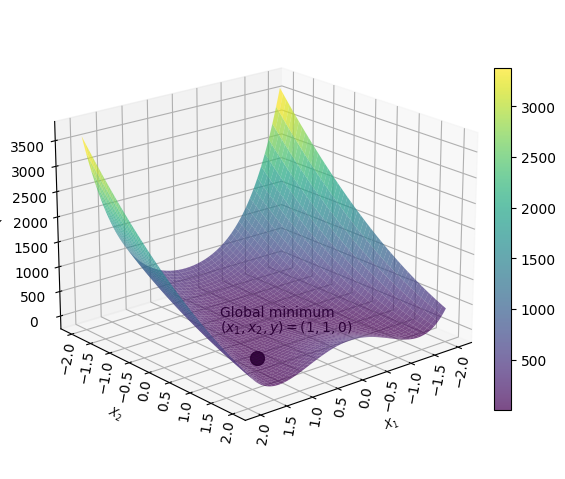

In [4]:
ofile= os.path.join(outputDir,'function_3D.png')
vsplt.plot_rosenbrock_3d(ofile)

#### 2. Generate input-output data

In [5]:
# If sampleFile exists, remove it to create a new one.
if os.path.exists(sampleFile):
    os.remove(sampleFile)

# Generate samples for input variables (x) using uniform sampling within their respective feasible ranges.
x = np.zeros((nSample,nVar))
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding function outputs (y).
y = Rosenbrock_function(x)

# Save input-output data (x,y).
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Input-output data saved: %s'%(sampleFile))

Input-output data saved: ./rosebrock/samples_nVar2.txt


#### 3. Visualize input-output data and their transformed data 
For example, if we compute the first-order sensitivity index of $X_1$, then two variables $(X_1,Y)$ are included in VISCOUS. Through data preparation, we will get three sets of data:
- $(x_1,y)$ : Original input-output data. 
- $(x'_{1},y')$: Normalized data in range of [0, 1] using min-max scaling.
- $(u_{x_1},u_y)$: Marginal Cumulative Distribution Function (CDF) data via rank transformation.

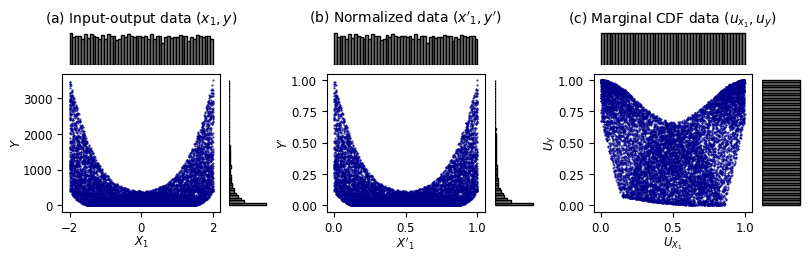

In [6]:
# --- Specify function arguments --- 
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Index of the evaluated input variable, starting from zero.
xIndex = 0   

# Output figure path
ofile = os.path.join(outputDir, f'x{xIndex + 1}_y.png')

# --- Plot ---
vsplt.plot_data_conversion(x,y,xIndex,ofile)

#### 4. Two Experiments 
- **Experiment 1**: Employing **two** Gaussian components. This visualization helps understanding the nature of Gaussian components and their grouping in forming the Gaussian Mixture Model (GMM).
- **Experiment 2**: Employing the **optimal** number of Gaussian components determined by VISCOUS within the range of [1, 9]. This helps demonstrating the impact of the Gaussian component count on VISCOUS performance.

#### Experiment 1: Calculate the first-order sensitivity index using two Gaussian components
The first-order sensitivity index indicates the sensitivity of the function output (e.g., Y) to a function input variable (e.g., X1), while keeping all other variables fixed. It represents the direct influence of an input variable on the model output. <br>

-----
Input argument explanations for the **vs.viscous** function:  
- **x**: array, shape **(n_samples, n_xvariables)**. Input values in the input space. 
- **y**: array, shape **(n_samples, 1)**. Output values in the output space. 
- **xIndex**: **int**. The index of the evaluated input variable, starting from zero. 
- **sensType**: **str**. Type of sensitivity index calculation. Options: 'first', 'total'. <br>
*Optional:*
- **N1**: **int**, optional, default: 2000. Number of Monte Carlo samples used for the outer loop of the Gaussian Mixture Copula Model (GMCM)-based sampling.
- **N2**: **int**, optional, default: 2000. Number of Monte Carlo samples used for the inner loop of the GMCM-based sampling.
- **n_components**: **{int, 'optimal'}**, optional, default: **'optimal'**. The number of components used in GMCM inference. If **'optimal'**, it looks for an optimal number of components in the range of **[1, 9]**.
- **MSC**: **str**, optional, default: **'AIC'**. Model selection criteria. Options: 'AIC', 'BIC'.
- **verbose**: **bool**, optional, default: **False**. Display detailed processing information on your screen.

For more detailed information about the function, please refer to the source code of **pyviscous**. <br>
Note that due to the randomness nature of the GMCM inference process, the GMCM inference results may vary slightly each time.

In [7]:
# --- Specify function arguments --- 
# Load input-output data.
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Index of the evaluated input variable, starting from zero.
xIndex = 0  # This means calculating X1's sensitivity index. 

# --- Calculate sensitivity index ---
sens_indx_2cpnt, gmcm_2cpnt = vs.viscous(x, y, xIndex, 'first', n_components=2)  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity index = 0.442747


#### Experiment 2: Calculate the first-order sensitivity index using the optimal Gaussian components

In [16]:
# --- Specify function arguments --- 
# Load input-output data.
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Index of the evaluated input variable, starting from zero.
xIndex = 0  # This means calculating X1's sensitivity index.  

# --- Calculate sensitivity index ---
sens_indx_optm, gmcm_optm = vs.viscous(x, y, xIndex, 'first', n_components='optimal') 

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  8
    Sensitivity index = 0.470555


#### 5. Results analysis

#### 5.1 Visualize the individual GMM components
When using two Gaussian components (Experiment 1), we plot the individual GMM components in the format of contour. A weighted mixture of all components constitutes the GMM. This plot is to help visualize how multiple Gaussian components constitute the GMM.

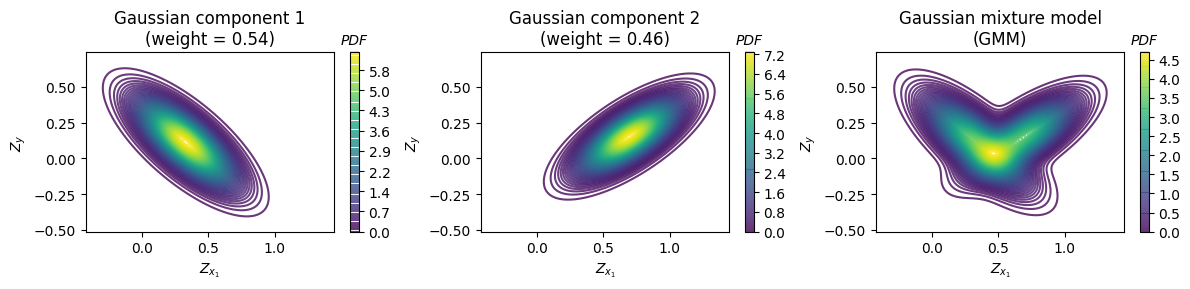

In [9]:
ofile = os.path.join(outputDir,'gmm_2cpnt_contour.png')  # Output figure path
vsplt.plot_gmm_counter(gmcm_2cpnt, x, y, xIndex, ofile)  # Plot

#### 5.2 Compare how the GMM aligns with the joint distribution of the input-output data 
To visualize how the GMM aligns with the input-output data, we do the following:
1. **Inverse CDF Computation**
- Recall that $(u_{x_1}, u_y)$ are the marginal CDFs for the provided input-output data (see Section 3 above). 
- Use the fitted GMM to compute the inverse CDF values of $(u_{x_1}, u_y)$ within the model, getting $(z_{x_1}, z_y)$. 
- Subplot (a) shows the distribution of $(z_{x_1}, z_y)$ data within the GMM.
2. **Probability Density Calculation**
- Next, compute the correspoding joint probability density for each data point $(z_{x_1}, z_y)$ based on the PDF of GMM.
- Subplot(b) shows the joint probability density value associated with each $(z_{x_1}, z_y)$.
- These probability density values play a crucial role in GMCM inference, specifically serving as key inputs for calculating the log-likelihood in the utilized Expectation-Maximization (EM) algorithm.
3. **Gaussain Component Analysis**
- Lastly, to see the appearance of different Gaussian components in the joint PDF of the GMM, we identify the most dominant Gaussian component for each $(z_{x_1}, z_y)$ — the component to which a data point belongs with the highest probability.
- Subplot(c) implicitly reveals each Gaussian component within the GMM PDF, providing insight into their characteristics.

Note: This function supports the first-order related plot. The representation of more than two dimensions in the total-order term presents technical challenges.

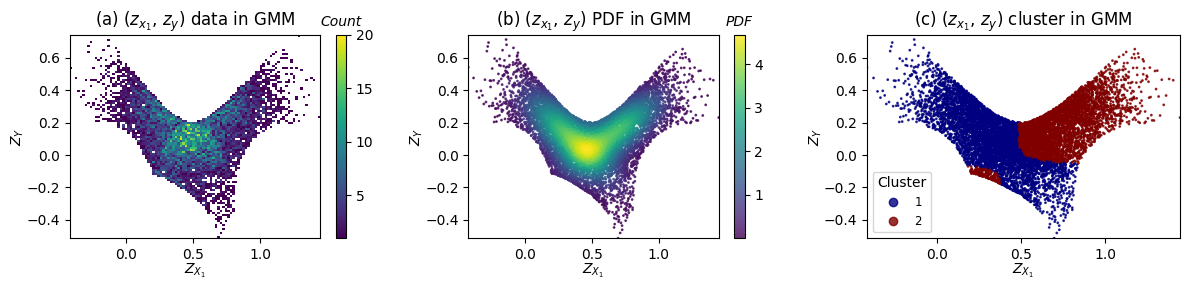

In [10]:
##### Expriment 1
ofile = os.path.join(outputDir,'gmm_2cpnt_joint_fit.png')            # Output figure path
vsplt.plot_gmm_joint_fit(gmcm_2cpnt,x, y, xIndex, ofile) # Plot

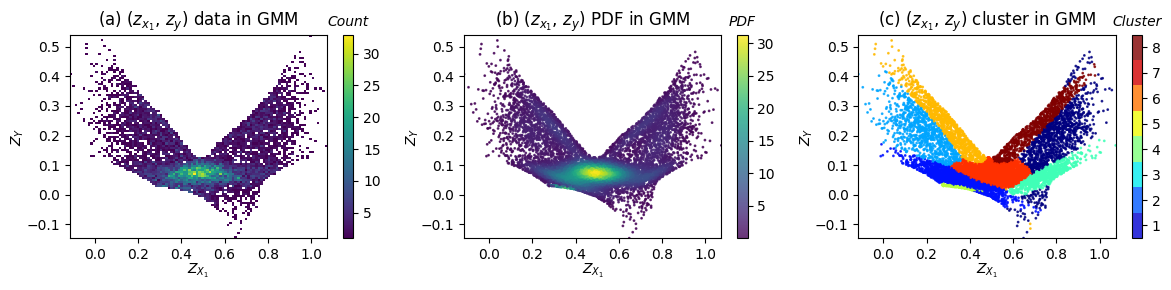

In [17]:
##### Expriment 2
ofile = os.path.join(outputDir,'gmm_optimal_cpnt_joint_fit.png')  # Output figure path
vsplt.plot_gmm_joint_fit(gmcm_optm,x,y,xIndex,ofile)  # Plot

#### 5.3 Compare how the GMM aligns with the marginal distributions of the input-output data
The following plots a histogram for each variable of $(z_{x_1}, z_y)$. The data point is labled with the Gaussian component to which it exhibits the highest probability. The GMM is considered more effective when its Gaussian components exhibit greater distinctiveness across all variable dimensions, effectively capturing the characteristics of each variable's data points.

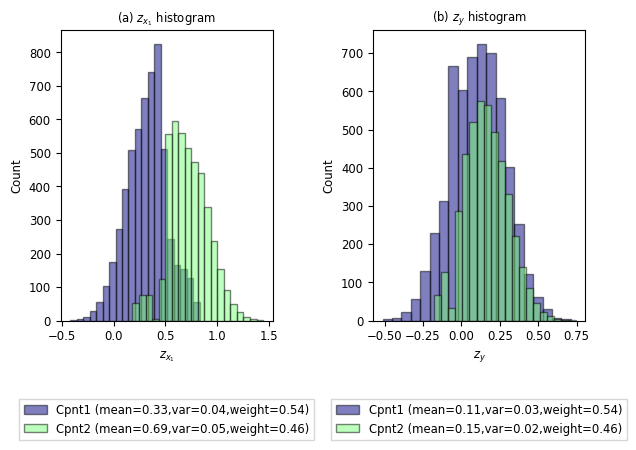

In [14]:
##### Expriment 1
ofile = os.path.join(outputDir,'gmm_2cpnt_marginal_fit.png')   # Output figure path
vsplt.plot_gmm_marginal_fit(gmcm_2cpnt, x, y, xIndex, ofile)   # Plot

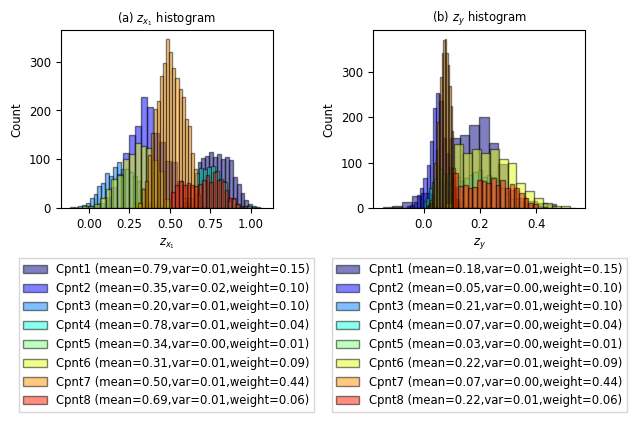

In [18]:
##### Expriment 2
ofile = os.path.join(outputDir,'gmm_optm_cpnt_marginal_fit.png')  # Output figure path
vsplt.plot_gmm_marginal_fit(gmcm_optm, x, y, xIndex, ofile)       # Plot